In [1]:
import os
from pathlib import Path
from collections import Counter

import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import pollock.utils as utils

In [2]:
disease = 'gbm'
module_save_filepath = f'/data/pollock/benchmarking/modules/snATACseq_{disease}_peaks'
result_dir = '/data/pollock/benchmarking/results/pollock/atac_peaks'
Path(module_save_filepath).mkdir(parents=True, exist_ok=True)
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [3]:
train = sc.read_h5ad(f'/data/pollock/benchmarking/pollock_datasets/snATACseq/{disease}_peaks_train.h5ad')
val = sc.read_h5ad(f'/data/pollock/benchmarking/pollock_datasets/snATACseq/{disease}_peaks_val.h5ad')
train.shape, val.shape

((3397, 149449), (2868, 149449))

In [4]:
# get least sparse peaks
m = (train.X!=0).sum(axis=0)
idxs = np.flip(np.argsort(np.asarray(m).flatten()))
train, val = train[:, idxs[:200000]], val[:, idxs[:200000]]
train.shape, val.shape

((3397, 149449), (2868, 149449))

In [5]:
import torch
torch.cuda.is_available()

True

In [6]:
args = utils.DEFAULT_TRAIN_ARGS
args['module_filepath'] = module_save_filepath
args['use_cuda'] = True
args

{'lr': 0.0001,
 'epochs': 20,
 'batch_size': 64,
 'latent_dim': 64,
 'enc_out_dim': 128,
 'middle_dim': 512,
 'kl_scaler': 0.001,
 'clf_scaler': 1.0,
 'zinb_scaler': 0.5,
 'use_cuda': True,
 'cell_type_key': 'cell_type',
 'module_filepath': '/data/pollock/benchmarking/modules/snATACseq_gbm_peaks'}

In [7]:
args['batch_size'] = 128

In [8]:
utils.train_and_save_model(train.copy(), val.copy(), args)

2022-03-24 09:30:09,432 beginning training
2022-03-24 09:30:09,433 creating dataloaders
2022-03-24 09:30:13,634 124815 genes overlap with model after filtering
2022-03-24 09:30:13,635 8496 genes missing from dataset after filtering
2022-03-24 09:30:18,036 creating model
2022-03-24 09:30:22,474 training dataset size: 3397, validation dataset size: 2868, cell types: ['B cell', 'Endothelial', 'Fibroblast', 'Malignant', 'Microglia', 'Neuron', 'Oligodendrocytes', 'T cells']
2022-03-24 09:30:22,475 fitting model
2022-03-24 09:30:32,520 epoch: 0, train loss: 2.246, val loss: 2.239, zinb loss: 0.338, kl loss: 0.685, clf loss: 2.069, time: 5.71
2022-03-24 09:30:42,424 epoch: 1, train loss: 2.234, val loss: 2.217, zinb loss: 0.331, kl loss: 2.330, clf loss: 2.050, time: 6.93
2022-03-24 09:30:52,315 epoch: 2, train loss: 2.169, val loss: 2.054, zinb loss: 0.289, kl loss: 41.090, clf loss: 1.869, time: 5.96
2022-03-24 09:31:00,699 epoch: 3, train loss: 1.938, val loss: 1.831, zinb loss: 0.182, kl 

In [9]:
model = utils.load_model(module_save_filepath)

In [10]:
# note that if you are predicting a large dataset and don't need the pollock umap embeddings you can set make_umap to False to increase runtime speed
adata = utils.predict_adata(model, val.copy(), make_umap=True)
adata

2022-03-24 09:33:09,955 124815 genes overlap with model after filtering
2022-03-24 09:33:09,956 8496 genes missing from dataset after filtering
2022-03-24 09:33:14,211 starting prediction of 2868 cells


AnnData object with n_obs × n_vars = 2868 × 133311
    obs: 'cell_type', 'barcode', 'sample', 'n_counts', 'size_factors', 'y_pred', 'predicted_cell_type_probability', 'predicted_cell_type', 'probability B cell', 'probability Endothelial', 'probability Fibroblast', 'probability Malignant', 'probability Microglia', 'probability Neuron', 'probability Oligodendrocytes', 'probability T cells'
    var: 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_emb', 'X_umap', 'prediction_probs'

In [11]:
adata.obs

,cell_type,barcode,sample,n_counts,size_factors,y_pred,predicted_cell_type_probability,predicted_cell_type,probability B cell,probability Endothelial,probability Fibroblast,probability Malignant,probability Microglia,probability Neuron,probability Oligodendrocytes,probability T cells
0_AACTGTGCACGCGCAT-1,Microglia,AACTGTGCACGCGCAT-1,0,5919.0,1.307633,4,0.939271,Microglia,0.005155,0.010098,0.010493,0.008943,0.939271,0.012679,0.009633,0.003727
0_AACGGGATCGTGAACT-1,Malignant,AACGGGATCGTGAACT-1,0,6191.0,1.367723,3,0.509321,Malignant,0.055757,0.045326,0.263711,0.509321,0.029484,0.033274,0.020219,0.042907
0_GGAGAACAGCAGTAGC-1,Microglia,GGAGAACAGCAGTAGC-1,0,6546.0,1.446150,4,0.757455,Microglia,0.020075,0.033392,0.036234,0.028169,0.757455,0.034688,0.070016,0.019971
0_CGCACAGTCCTCCTGA-1,Fibroblast,CGCACAGTCCTCCTGA-1,0,8255.0,1.823705,2,0.817721,Fibroblast,0.025192,0.032007,0.817721,0.043527,0.021855,0.015994,0.014169,0.029535
0_CAGTATGAGCGATACG-1,Oligodendrocytes,CAGTATGAGCGATACG-1,0,2456.0,0.542583,6,0.887631,Oligodendrocytes,0.018635,0.006778,0.008006,0.016870,0.028860,0.012671,0.887631,0.020548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_CTTCTAATCCAAGTCA-1,Malignant,CTTCTAATCCAAGTCA-1,9,12509.0,2.763504,3,0.958068,Malignant,0.007057,0.004681,0.002329,0.958068,0.006800,0.010830,0.005036,0.005200
9_GTCACCTAGACCATAA-1,Endothelial,GTCACCTAGACCATAA-1,9,6637.0,1.466254,2,0.436717,Fibroblast,0.039406,0.315975,0.436717,0.036066,0.044237,0.041598,0.013941,0.072060
9_CACTAAGTCCCGAAGC-1,Malignant,CACTAAGTCCCGAAGC-1,9,4071.0,0.899370,6,0.755595,Oligodendrocytes,0.052421,0.014711,0.014245,0.068892,0.034976,0.024025,0.755595,0.035135
9_TTCATCATCTGACTTT-1,Microglia,TTCATCATCTGACTTT-1,9,3645.0,0.805258,4,0.860229,Microglia,0.012745,0.024865,0.025591,0.020444,0.860229,0.023797,0.021590,0.010739


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


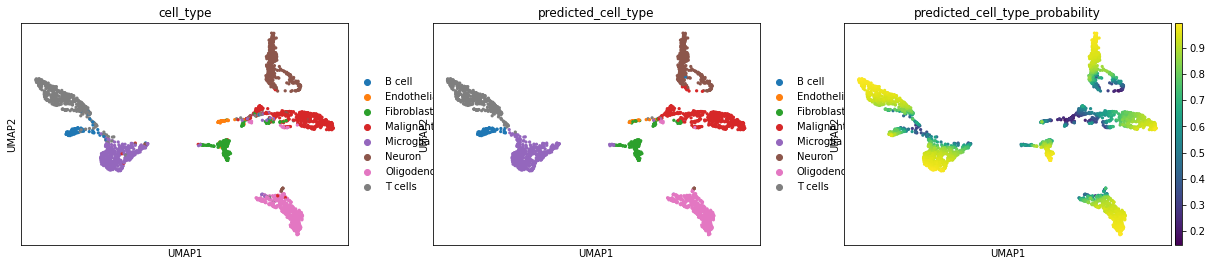

In [12]:
sc.pl.umap(adata, color=['cell_type', 'predicted_cell_type', 'predicted_cell_type_probability'])

In [13]:
def get_metrics(y_true_labels, y_pred_labels):
    classes = sorted(set(y_true_labels))

    y_pred = [classes.index(c) for c in y_pred_labels]
    y_true = [classes.index(c) for c in y_true_labels]

    clf_report = classification_report(y_true, y_pred, labels=list(range(len(classes))), target_names=classes,
                             output_dict=True)
    clf_report = pd.DataFrame.from_dict(clf_report)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    cm = pd.DataFrame(data=cm, index=classes, columns=classes)
    
    clf_report.index.name = 'metric'
    cm.index.name = 'cell_type'
    
    return clf_report, cm

In [14]:
# using only validation anndata to look at performance metrics
y_pred = adata.obs['predicted_cell_type'].to_list()
y_true = adata.obs['cell_type'].to_list()
clf_report, cm = get_metrics(y_true, y_pred)

Text(32.99999999999999, 0.5, 'manual annotation')

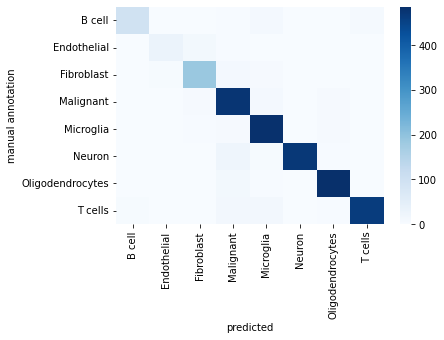

In [15]:
sns.heatmap(cm, cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('manual annotation')

Text(32.99999999999999, 0.5, 'manual annotation')

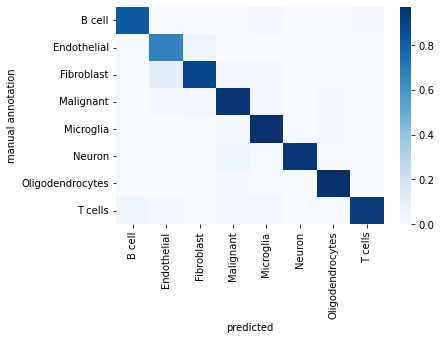

In [16]:
sns.heatmap(cm / cm.sum(axis=1), cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('manual annotation')

In [17]:
clf_report

,B cell,Endothelial,Fibroblast,Malignant,Microglia,Neuron,Oligodendrocytes,T cells,accuracy,macro avg,weighted avg
metric,,,,,,,,,,,
precision,0.940594,0.833333,0.899038,0.869963,0.911488,0.997872,0.962376,0.983015,0.937587,0.924710,0.939703
recall,0.818966,0.666667,0.903382,0.950000,0.968000,0.938000,0.972000,0.926000,0.937587,0.892877,0.937587
f1-score,0.875576,0.740741,0.901205,0.908222,0.938894,0.967010,0.967164,0.953656,0.937587,0.906559,0.937560
support,116.000000,45.000000,207.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.937587,2868.000000,2868.000000


In [18]:
clf_report.to_csv(os.path.join(result_dir, f'{disease}_clf_report.txt'), sep='\t')
cm.to_csv(os.path.join(result_dir, f'{disease}_confusion_matrix.txt'), sep='\t')